# Model Selection: Baseline Models

This notebook evaluates multiple baseline regression models using cross-validation to identify the best performing model for the tabular regression task.

## 1. Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## 2. Data Loading and Preprocessing

Load the training data and apply initial filtering to remove invalid entries.

In [2]:
df = pd.read_csv("../data/CW1_train.csv")
# Remove physically impossible dimensions identified in the EDA
df = df[(df["x"] > 0) & (df["y"] > 0) & (df["z"] > 0) & (df["y"] <= 10)]

Separate features and target variable.

In [3]:
X = df.drop(columns=["outcome"])
Y = df["outcome"]

## 3. Feature Engineering

Create derived features including volume and log-transformed price and carat features.

In [4]:
from sklearn.preprocessing import FunctionTransformer

def feature_engineering(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df["volume"] = df["x"] * df["y"] * df["z"]
    df["log_price"] = np.log1p(df["price"])
    df["log_carat"] = np.log1p(df["carat"])
    return df.drop(columns=["x", "y", "z", "carat", "price"])

feature_engineering_transformer = FunctionTransformer(
    feature_engineering,
    validate=False,
    check_inverse=False
)

## 4. Preprocessing Pipeline

Build a preprocessor that standardizes numerical features and encodes categorical features using ordinal encoding with predefined orderings.

In [5]:
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer, make_column_selector

cut_order = ["Fair", "Good", "Very Good", "Premium", "Ideal"]
colour_order = ["J", "I", "H", "G", "F", "E", "D"]
clarity_order = ["I1", "SI2", "SI1", "VS2", "VS1", "VVS2", "VVS1", "IF"]

def build_preprocessor() -> ColumnTransformer:
    categorical_columns = ["cut", "color", "clarity"]

    return ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), make_column_selector(dtype_include=np.number)),
            ("cat", OrdinalEncoder(categories=[cut_order, colour_order, clarity_order]), categorical_columns),
        ],
    )


Create a pipeline that combines feature engineering, preprocessing, and the model.

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator

def build_pipeline(model: BaseEstimator) -> Pipeline:
    return Pipeline(steps=[
        ("feature_engineering", feature_engineering_transformer),
        ("preprocessor", build_preprocessor()),
        ("model", model)
    ])

## 5. Model Definitions

Define a collection of baseline models to evaluate, including linear models, tree-based models, and other regression algorithms.

In [7]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor

models = {
    "Linear Regression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "ElasticNet": ElasticNet(),
    "KNN": KNeighborsRegressor(),
    "SVR": SVR(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42, verbosity=0),
}


## 6. Cross-Validation Evaluation

Evaluate each model using 5-fold cross-validation with R² as the scoring metric.

In [8]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold


results = {}
cross_validation = KFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    pipeline = build_pipeline(model)
    scores = cross_val_score(pipeline, X, Y, cv=cross_validation, scoring="r2")
    results[name] = {
        "Mean R²": scores.mean(),
        "Std R²": scores.std()
    }
    print(f"{name}: {scores.mean():.4f} ± {scores.std():.4f}")

Linear Regression: 0.2844 ± 0.0194
Ridge: 0.2844 ± 0.0194
Lasso: 0.2552 ± 0.0122
ElasticNet: 0.2322 ± 0.0097
KNN: 0.0661 ± 0.0138
SVR: 0.3082 ± 0.0188
Random Forest: 0.4544 ± 0.0237
Gradient Boosting: 0.4721 ± 0.0189
XGBoost: 0.3937 ± 0.0226


### Results Summary

Display the results sorted by mean R² score.

In [9]:
results_df = pd.DataFrame(results).T.sort_values("Mean R²", ascending=False)
results_df

,Mean R²,Std R²
Gradient Boosting,0.472111,0.018896
Random Forest,0.454372,0.023684
XGBoost,0.393749,0.022617
SVR,0.308158,0.018849
Ridge,0.284361,0.019386
Linear Regression,0.284354,0.019395
Lasso,0.255223,0.012192
ElasticNet,0.232234,0.009716
KNN,0.066136,0.013814


### Visualization

Create a horizontal bar chart comparing model performance with error bars showing standard deviation.

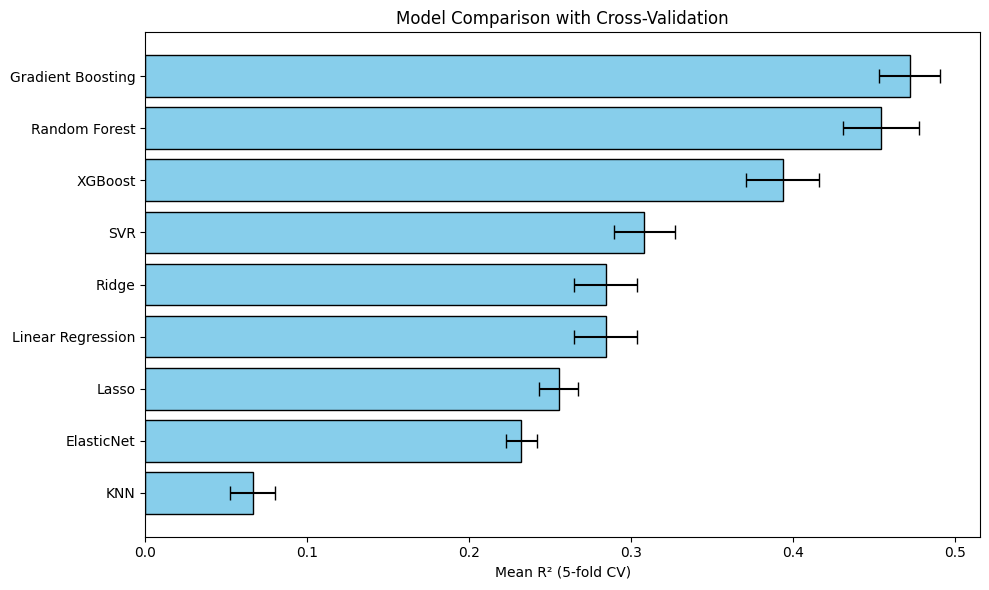

In [10]:
plt.figure(figsize=(10,6))

plt.barh(
    results_df.index,
    results_df["Mean R²"],
    xerr=results_df["Std R²"],
    capsize=5,            
    color="skyblue",      
    edgecolor="black"
)

plt.xlabel("Mean R² (5-fold CV)")
plt.title("Model Comparison with Cross-Validation")
plt.gca().invert_yaxis()

plt.tight_layout()
plt.savefig("../figures/model_comparison_cv.png", dpi=300)
plt.show()
